# Assignment 1, ECE9309 Machine Learning
**Group 21**
_B. Dudley, N. Mitchell, B. Shan, and E. Simpson_

## Dependencies

Import stuff and declare some global variables that are useful later.

In [55]:
import os
import warnings
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from numpy import linalg as LA

from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics

# csv names
file_name_normal = "merged_exp_normal.csv"
file_name_anomalies = "merged_exp_contains_anomalies.csv"

# Question 1
> Optimise parameter epsilon in assignment 1 by:
> - minimizing the amount of generated false alarms 
> - increase the number of true anomalies discovered 

We will proceed by looking at the ROC/AUC curve. The optimal value of episilon is the one that jointly maximizes the number of true anomalies discovered and mimizes the number of false positives.  The value of epsilon that does this is the one which results in a point on the ROC cuve that is closest to the top left corner of the ROC curve plot.

## Multivariant dependant gaussian attempt 1
### HINT DO NOT USE roc_curve function it will not work for our question!!!

In [57]:
experiment = 'HEAT_ID_01_ALARM_OUT_tag' # experiment to use

# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)
# select only rows from the experiment to use
df_anomaly = df_anomaly[df_anomaly['experiment']==experiment] 

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

# calculate the covariance matrix 
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
means = df_normal.mean()
cov = df_normal.cov()

# find the probability of all the new values 
prob = df_anomaly.apply(lambda x: stats.multivariate_normal.pdf(x.to_numpy(),
                                                            means.to_numpy(),
                                                            cov.to_numpy()), axis=1)
pAnom = pd.DataFrame({'Prob': prob})
pAnom['Anomaly_Tag'] = true_labels

In [58]:
pAnom.describe()

Prob  Anomaly_Tag
count  2.180000e+03  2180.000000
mean   4.598793e-05     0.186239
std    4.136373e-05     0.389388
min    0.000000e+00     0.000000
25%    7.888452e-39     0.000000
50%    4.334489e-05     0.000000
75%    8.770719e-05     0.000000
max    1.376700e-04     1.000000

### Get the False positive rate and True positive rate for a wide variety of thresholds. Determine the AUC (area under the curve) using trapezoidal rule as well 

In [59]:
fpr,tpr,threshold = roc_curve(pAnom['Anomaly_Tag'], pAnom['Prob'])
roc_auc = auc(fpr, tpr)

In [60]:
dot1 = 171 # green
dot2 = 358 # light blue 


# Plot the graph
plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.plot(fpr[dot1],tpr[dot1],'go',markersize=6)
plt.plot(fpr[dot2],tpr[dot2],'co',markersize=6)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
print('Threshold 1 = '+str(threshold[dot1]))
print('Threshold 2 = '+str(threshold[dot2]))

Threshold 1 = 1.716720670046432e-08
Threshold 2 = 2.3631311265290747e-141


Objectively I think that the best choice for epsilon (where the slop is the highest) is threshold 1 and threshold 2, funny enough the lower the threshold the larger the FPR and TPR become. This is something due to the roc curve that was implemented. It assumed that the calculation was done based on the value has to be GREATER than the treshold. We need one that is SMALLER than the threshold. Time to do a different implementation 

## Multivariant dependant gaussian attempt 2

#### Calculate the probability for all dependant multivariate gaussian 

In [62]:
experiment = 'HEAT_ID_01_ALARM_OUT_tag' # experiment to use

# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

# calculate the covariance matrix 
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
means = df_normal.mean()
cov = df_normal.cov()

# find the probability of all the new values 
prob = df_anomaly.apply(lambda x: stats.multivariate_normal.pdf(x.to_numpy(),
                                                            means.to_numpy(),
                                                            cov.to_numpy()), axis=1)
pAnom = pd.DataFrame({'Prob': prob})
pAnom['Anomaly_Tag'] = true_labels
pAnom.boxplot(column=['Prob'])

In [63]:
pAnom.describe()

Prob   Anomaly_Tag
count  4.562600e+04  45626.000000
mean   2.551446e-05      0.140950
std    3.426382e-05      0.347974
min    0.000000e+00      0.000000
25%    8.859846e-10      0.000000
50%    6.140572e-06      0.000000
75%    4.375461e-05      0.000000
max    1.385553e-04      1.000000

### Calculate TP, FP, FN, TN, TPR and FPR 

In [64]:
# Initiate lists
TPR = []
FPR = []
TrackEpsilon = []

for i in range(1,70,1):
    for j in range(1,9):
        epsilon =  j*10/(10**(i))
        #epsilon = 1/i
        # make the predicition based on epsilon 
        pAnom['PredictedTag'] = np.where(pAnom['Prob']<=epsilon, 1, 0)
        TP = np.sum(pAnom['PredictedTag'][true_labels==1]==1)
        FP = np.sum(pAnom['PredictedTag'][true_labels == 0] == 1)
        FN = np.sum(pAnom['PredictedTag'][true_labels == 1] == 0)
        TN = np.sum(pAnom['PredictedTag'][true_labels == 0] == 0)
        TPR.append(TP/(TP+FN))
        FPR.append(1-(TN/(TN+FP)))
        TrackEpsilon.append(epsilon)
    
print(pAnom)    
# make dataframes from TP, FP, Epsilon
optimize_df = pd.DataFrame({'tpr': TPR,'fpr': FPR,'Epsilon':TrackEpsilon})
print(optimize_df)

          Prob  Anomaly_Tag  PredictedTag
745   0.000000            0             1
746   0.000000            0             1
747   0.000000            0             1
748   0.000000            0             1
749   0.000000            0             1
...        ...          ...           ...
3268  0.000015            0             0
3269  0.000013            0             0
3270  0.000014            0             0
3271  0.000012            0             0
3272  0.000013            0             0

[45626 rows x 3 columns]
          tpr       fpr       Epsilon
0    1.000000  1.000000  1.000000e+00
1    1.000000  1.000000  2.000000e+00
2    1.000000  1.000000  3.000000e+00
3    1.000000  1.000000  4.000000e+00
4    1.000000  1.000000  5.000000e+00
..        ...       ...           ...
547  0.102317  0.091466  4.000000e-68
548  0.102472  0.091542  5.000000e-68
549  0.102783  0.091568  6.000000e-68
550  0.103405  0.091644  7.000000e-68
551  0.103405  0.091695  8.000000e-68

[552 rows x 3

### Sort the values based on ascending tpr because the graph looks weird otherwise! 

In [65]:
optimize_df = optimize_df.sort_values('tpr')
optimize_df = optimize_df.reset_index()
optimize_df.head()

index       tpr       fpr       Epsilon
0    544  0.101695  0.091211  1.000000e-68
1    546  0.102006  0.091415  3.000000e-68
2    545  0.102006  0.091287  2.000000e-68
3    547  0.102317  0.091466  4.000000e-68
4    548  0.102472  0.091542  5.000000e-68

### Plot the ROC curve

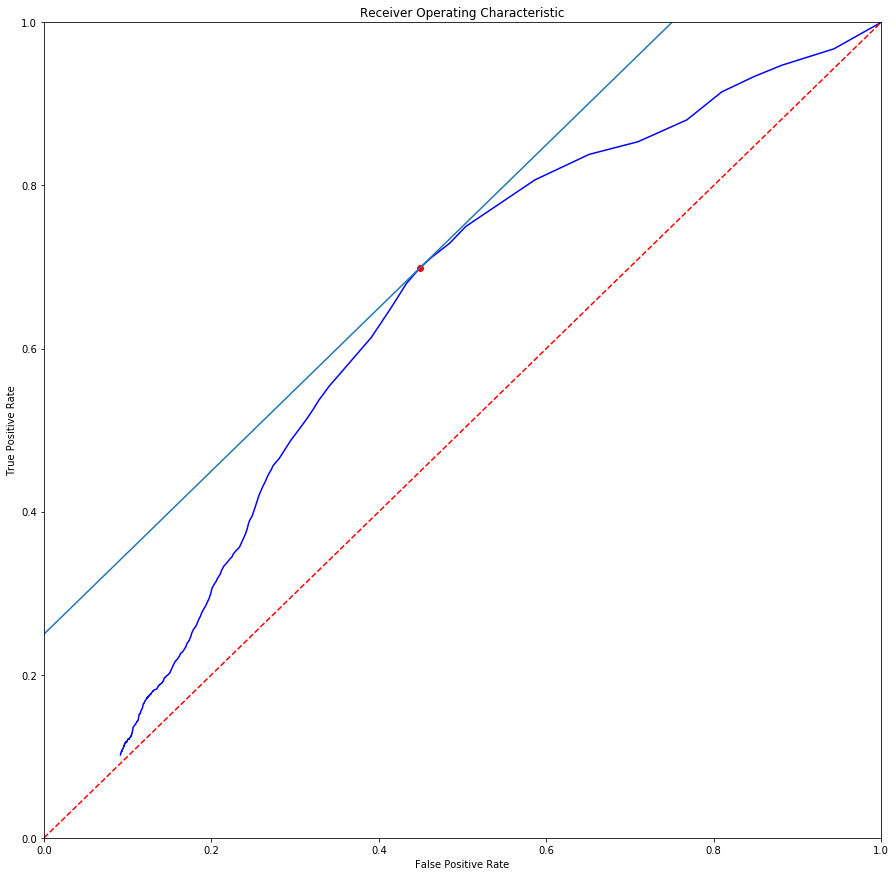

In [66]:
# the point that maximizes the TPR while minimzing the FPR 
# (assuming equal weight) lies on a line with a slope = 1
# that maximizies the y intercept

intercept = optimize_df['tpr'] - optimize_df['fpr']
i_optimal = intercept.values.argmax()     # index of optimal threshold

# method I: plt
plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic')
plt.plot(optimize_df['fpr'],optimize_df['tpr'], 'b')
plt.plot([0, 1], [0, 1],'r--')

# plot optimal point and line w/slope 1 through optimal
plt.plot(optimize_df['fpr'].iloc[i_optimal],
         optimize_df['tpr'].iloc[i_optimal],
         'ro')
x = np.linspace(0,1)
plt.plot(x, 1 * x  + intercept.iloc[i_optimal])

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [67]:
print('Epsilon = '+str(optimize_df.at[i_optimal,'Epsilon']))

Epsilon = 5e-06


Objectively I think that the best choice for epsilon (where the slope is the highest) is at e = 5e-6 ! 

## Multivariate Independant Gaussian attempt 1

In [68]:
def find_prob(X, means, stds, epsilon):
    p = 1; # initialize p
    for i in range(0,len(X)):
        p *= stats.norm.pdf(X[i],means[i],stds[i])
    return p

### Get the probabilities for all cases in the anomaly test set

In [69]:
# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about, leaving x1-x8
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

# means and stds for gaussian
means = df_normal.mean()
stds = df_normal.std()


# apply the alarm to the experiement
prob2 = df_anomaly.apply(lambda x: find_prob(x, means, stds, epsilon), axis=1)
pAnom = pd.DataFrame({'Prob': prob2})
pAnom['Anomaly_Tag'] = true_labels
pAnom.describe()

Prob   Anomaly_Tag
count  4.562600e+04  45626.000000
mean   1.267672e-07      0.140950
std    9.398464e-08      0.347974
min    0.000000e+00      0.000000
25%    1.786902e-08      0.000000
50%    1.392743e-07      0.000000
75%    2.194192e-07      0.000000
max    2.621279e-07      1.000000

In [70]:
pAnom.boxplot(column=['Prob'])

### Calculate TP, FP, FN, TN, TPR and FPR 

In [71]:
# Initiate lists
TPR = []
FPR = []
TrackEpsilon = []

for i in range(1,70,1):
    for j in range(1,9):
        epsilon =  j*10/(10**(i))
        #epsilon = 1/i
        # make the predicition based on epsilon 
        pAnom['PredictedTag'] = np.where(pAnom['Prob']<=epsilon, 1, 0)
        TP = np.sum(pAnom['PredictedTag'][true_labels==1]==1)
        FP = np.sum(pAnom['PredictedTag'][true_labels == 0] == 1)
        FN = np.sum(pAnom['PredictedTag'][true_labels == 1] == 0)
        TN = np.sum(pAnom['PredictedTag'][true_labels == 0] == 0)
        TPR.append(TP/(TP+FN))
        FPR.append(1-(TN/(TN+FP)))
        TrackEpsilon.append(epsilon)
    
print(pAnom)    
# make dataframes from TP, FP, Epsilon
optimize_df2 = pd.DataFrame({'tpr': TPR,'fpr': FPR,'Epsilon':TrackEpsilon})
print(optimize_df2)

              Prob  Anomaly_Tag  PredictedTag
745   0.000000e+00            0             1
746   0.000000e+00            0             1
747   0.000000e+00            0             1
748   0.000000e+00            0             1
749   0.000000e+00            0             1
...            ...          ...           ...
3268  1.100006e-07            0             0
3269  1.096111e-07            0             0
3270  1.128538e-07            0             0
3271  1.147769e-07            0             0
3272  1.186392e-07            0             0

[45626 rows x 3 columns]
          tpr       fpr       Epsilon
0    1.000000  1.000000  1.000000e+00
1    1.000000  1.000000  2.000000e+00
2    1.000000  1.000000  3.000000e+00
3    1.000000  1.000000  4.000000e+00
4    1.000000  1.000000  5.000000e+00
..        ...       ...           ...
547  0.023169  0.047353  4.000000e-68
548  0.023169  0.047378  5.000000e-68
549  0.023169  0.047404  6.000000e-68
550  0.023169  0.047404  7.000000e-68
551 

### Make sure that the values are properly sorted so the graph isn't jumping all over the place!

In [72]:
optimize_df2 = optimize_df2.sort_values('tpr')
optimize_df2 = optimize_df2.reset_index()
optimize_df2.head()

index       tpr       fpr       Epsilon
0    544  0.022703  0.047276  1.000000e-68
1    545  0.023014  0.047302  2.000000e-68
2    551  0.023169  0.047404  8.000000e-68
3    549  0.023169  0.047404  6.000000e-68
4    548  0.023169  0.047378  5.000000e-68

### Plot the ROC curve

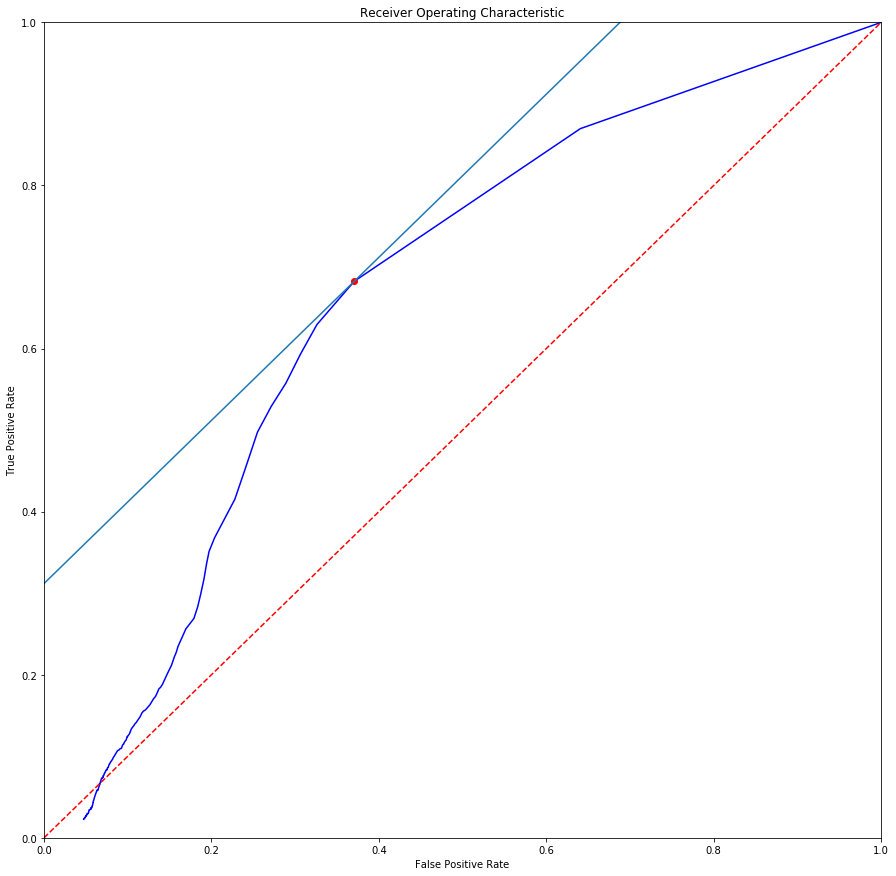

In [73]:
# the point that maximizes the TPR while minimzing the FPR 
# (assuming equal weight) lies on a line with a slope = 1
# that maximizies the y intercept

intercept_mvg = optimize_df2['tpr'] - optimize_df2['fpr']
i_optimal_mvg = intercept_mvg.values.argmax()     # index of optimal threshold

# method I: plt
plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic')
plt.plot(optimize_df2['fpr'],optimize_df2['tpr'], 'b')
plt.plot([0, 1], [0, 1],'r--')

# plot optimal point and line w/slope 1 through optimal
plt.plot(optimize_df2['fpr'].iloc[i_optimal_mvg],
         optimize_df2['tpr'].iloc[i_optimal_mvg],
         'ro')
x = np.linspace(0,1)
plt.plot(x, 1 * x  + intercept_mvg.iloc[i_optimal_mvg])

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [75]:
print('Epsilon = '+str(optimize_df2.at[i_optimal_mvg,'Epsilon']))

Epsilon = 1e-07


My optimised value for this problem is 1e-7, because it is roughly the area where the slope of the ROC curve starts to decline. 

# Question 2
## Do the features in the gaussian models actually follow the gaussian distribution? If not transform them such that they do! 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002594790EB48>,
      dtype=object)

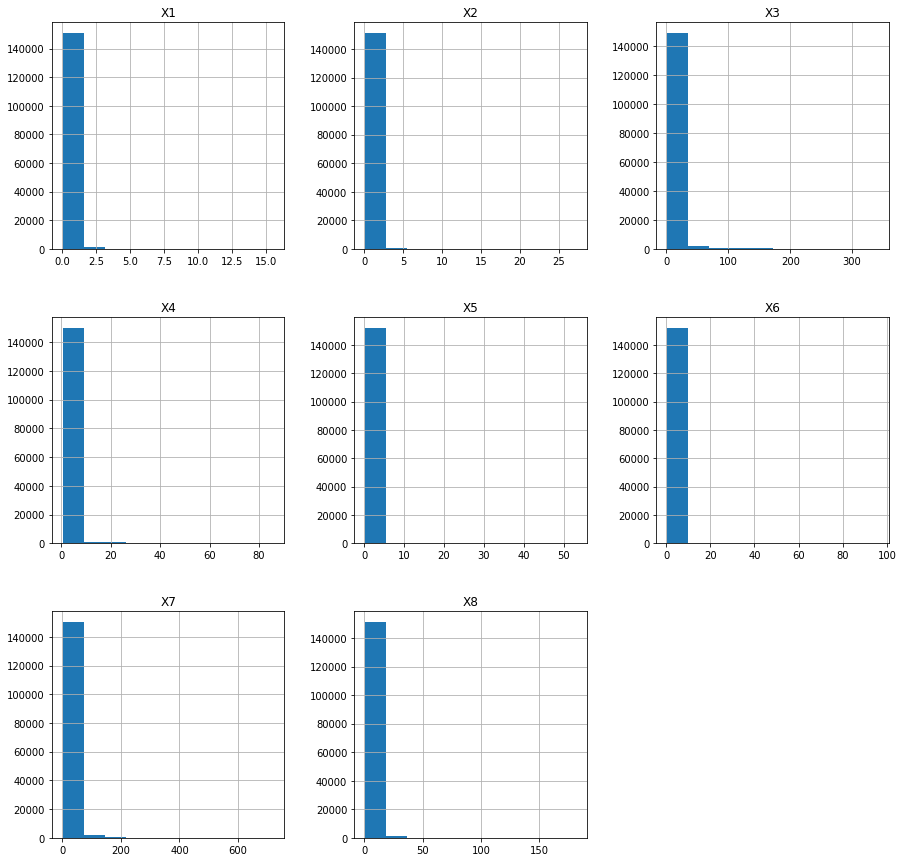

In [76]:
# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# select only the columns we care about, leaving x1-x8
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

# now plot the histograms of the values x1-x8, they SHOULD** look like the bell curve
df_normal.hist(bins=10,figsize=(15,15))

### They do not follow a gaussian distribution, so we need to transform them such that they do! 

In [77]:
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

# load the normal data
df_normal = pd.read_csv(file_name_normal, index_col = 0)

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# separate the anomaly tags
true_labels = df_anomaly['Anomaly_Tag']

# select only the columns we care about, leaving x1-x8
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
df_normal.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)

# define the transform that we want to operate with (yeo-johnson is better with positive and negative, box-cox is better with str)
bc = PowerTransformer(method='box-cox')
yj = PowerTransformer(method='yeo-johnson')

### Try box-cox transform first

In [78]:
# perform power transform box cox and print histograms 
Transform = bc.fit(df_normal).transform(df_anomaly)
Transform = pd.DataFrame(Transform)
Transform.hist(bins=10,figsize=(15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002594774F608>,
      dtype=object)

### try yeo-johnson transform second 

In [79]:
# perform power transform box cox and print histograms 
Transform = yj.fit(df_normal).transform(df_anomaly)
Transform = pd.DataFrame(Transform)
Transform.hist(bins=10,figsize=(15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025947820588>,
      dtype=object)

objectively I would say that the box-cox transform provides the more gaussian like curves ! 

## Multivariate Gaussian with transformed variables 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45626 entries, 0 to 45625
Data columns (total 1 columns):
Prob    45626 non-null float64
dtypes: float64(1)
memory usage: 356.6 KB


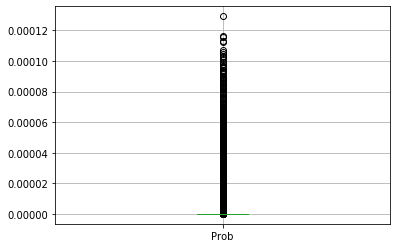

In [80]:
# find the probability of all the new values 
prob = Transform.apply(lambda x: stats.multivariate_normal.pdf(x.to_numpy(),
                                                            means.to_numpy(),
                                                            cov.to_numpy()), axis=1)
pAnom = pd.DataFrame({'Prob': prob})
pAnom.info()


true_labels = true_labels.reset_index(drop=True)
true_labels.head()
pAnom['Anomaly_Tag'] = true_labels
pAnom.boxplot(column=['Prob'])

In [81]:
# Initiate lists
TPR = []
FPR = []
TrackEpsilon = []

for i in range(1,70,1):
    for j in range(1,9):
        epsilon =  j*10/(10**(i))
        #epsilon = 1/i
        # make the predicition based on epsilon 
        pAnom['PredictedTag'] = np.where(pAnom['Prob']<=epsilon, 1, 0)
        TP = np.sum(pAnom['PredictedTag'][true_labels==1]==1)
        FP = np.sum(pAnom['PredictedTag'][true_labels == 0] == 1)
        FN = np.sum(pAnom['PredictedTag'][true_labels == 1] == 0)
        TN = np.sum(pAnom['PredictedTag'][true_labels == 0] == 0)
        TPR.append(TP/(TP+FN))
        FPR.append(1-(TN/(TN+FP)))
        TrackEpsilon.append(epsilon)
    
print(pAnom)    
# make dataframes from TP, FP, Epsilon
optimize_df3 = pd.DataFrame({'tpr': TPR,'fpr': FPR,'Epsilon':TrackEpsilon})
print(optimize_df3)

               Prob  Anomaly_Tag  PredictedTag
0      2.848982e-50            0             0
1      9.363976e-47            0             0
2      4.795065e-49            0             0
3      6.786900e-49            0             0
4      4.812921e-52            0             0
...             ...          ...           ...
45621  6.849918e-07            0             0
45622  1.591822e-07            0             0
45623  4.792093e-08            0             0
45624  1.333252e-09            0             0
45625  7.194750e-10            0             0

[45626 rows x 3 columns]
     tpr       fpr       Epsilon
0    1.0  1.000000  1.000000e+00
1    1.0  1.000000  2.000000e+00
2    1.0  1.000000  3.000000e+00
3    1.0  1.000000  4.000000e+00
4    1.0  1.000000  5.000000e+00
..   ...       ...           ...
547  0.0  0.002960  4.000000e-68
548  0.0  0.002985  5.000000e-68
549  0.0  0.002985  6.000000e-68
550  0.0  0.002985  7.000000e-68
551  0.0  0.002985  8.000000e-68

[552 rows x 3

In [82]:
optimize_df3 = optimize_df3.sort_values('tpr')
optimize_df3 = optimize_df3.reset_index()
optimize_df3.head()

index  tpr       fpr       Epsilon
0    551  0.0  0.002985  8.000000e-68
1    445  0.0  0.004516  6.000000e-55
2    444  0.0  0.004465  5.000000e-55
3    443  0.0  0.004439  4.000000e-55
4    442  0.0  0.004439  3.000000e-55

In [90]:
# the point that maximizes the TPR while minimzing the FPR 
# (assuming equal weight) lies on a line with a slope = 1
# that maximizies the y intercept

intercept_trans = optimize_df3['tpr'] - optimize_df3['fpr']
i_optimal_trans = intercept_trans.values.argmax()     # index of optimal threshold


# method I: plt
plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic Multivariate Gaussian Dependant')
plt.plot(optimize_df3['fpr'],optimize_df3['tpr'], 'c',label='Transformed')
plt.plot(optimize_df['fpr'],optimize_df['tpr'], 'b',label='original')
plt.legend()
plt.plot([0, 1], [0, 1],'r--')

# plot optimal point and line w/slope 1 through optimal
plt.plot(optimize_df['fpr'].iloc[i_optimal],
         optimize_df['tpr'].iloc[i_optimal],
         'ro')
x = np.linspace(0,1)
plt.plot(x, 1 * x  + intercept.iloc[i_optimal])

# plot optimal point and line w/slope 1 through optimal
plt.plot(optimize_df3['fpr'].iloc[i_optimal_trans],
         optimize_df3['tpr'].iloc[i_optimal_trans],
         'ro')
x = np.linspace(0,1)
plt.plot(x, 1 * x  + intercept_trans.iloc[i_optimal_trans])

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [91]:
print('Gaussian Original')
print('Epsilon = '+str(optimize_df.at[i_optimal,'Epsilon']))
print('False Positive Rate = '+str(optimize_df.at[i_optimal,'fpr']))
print('True Positive Rate = '+str(optimize_df.at[i_optimal,'tpr']))
print('\n')
print('Gaussian Transformed')
print('Epsilon = '+str(optimize_df3.at[i_optimal_trans,'Epsilon']))
print('False Positive Rate = '+str(optimize_df3.at[i_optimal_trans,'fpr']))
print('True Positive Rate = '+str(optimize_df3.at[i_optimal_trans,'tpr']))

Gaussian Original
Epsilon = 5e-06
False Positive Rate = 0.44873070544712335
True Positive Rate = 0.6986471777328565


Gaussian Transformed
Epsilon = 5e-16
False Positive Rate = 0.2741421099630055
True Positive Rate = 0.6072150520914321


As it can be seen, the false positive rate is slight lower when it is transformed (which is good!) and the true positive rate is slightly higher/ the same (which is also good!). 

## Independant Gaussian Transformed

In [85]:
# apply the alarm to the experiement
prob2 = Transform.apply(lambda x: find_prob(x, means, stds, epsilon), axis=1)
pAnom = pd.DataFrame({'Prob': prob2})
pAnom['Anomaly_Tag'] = true_labels
pAnom.describe()

Prob   Anomaly_Tag
count  4.562600e+04  45626.000000
mean   4.311112e-08      0.140950
std    4.719919e-08      0.347974
min    1.420406e-14      0.000000
25%    2.507910e-09      0.000000
50%    2.477777e-08      0.000000
75%    7.323145e-08      0.000000
max    2.115430e-07      1.000000

In [86]:
# Initiate lists
TPR = []
FPR = []
TrackEpsilon = []

for i in range(1,70,1):
    for j in range(1,9):
        epsilon =  j*10/(10**(i))
        #epsilon = 1/i
        # make the predicition based on epsilon 
        pAnom['PredictedTag'] = np.where(pAnom['Prob']<=epsilon, 1, 0)
        TP = np.sum(pAnom['PredictedTag'][true_labels==1]==1)
        FP = np.sum(pAnom['PredictedTag'][true_labels == 0] == 1)
        FN = np.sum(pAnom['PredictedTag'][true_labels == 1] == 0)
        TN = np.sum(pAnom['PredictedTag'][true_labels == 0] == 0)
        TPR.append(TP/(TP+FN))
        FPR.append(1-(TN/(TN+FP)))
        TrackEpsilon.append(epsilon)
    
print(pAnom)    
# make dataframes from TP, FP, Epsilon
optimize_df4 = pd.DataFrame({'tpr': TPR,'fpr': FPR,'Epsilon':TrackEpsilon})
print(optimize_df4)

               Prob  Anomaly_Tag  PredictedTag
0      2.314650e-12            0             0
1      2.623912e-12            0             0
2      2.573729e-12            0             0
3      2.640263e-12            0             0
4      2.518351e-12            0             0
...             ...          ...           ...
45621  1.499720e-07            0             0
45622  1.483427e-07            0             0
45623  1.413240e-07            0             0
45624  1.208641e-07            0             0
45625  1.222098e-07            0             0

[45626 rows x 3 columns]
     tpr  fpr       Epsilon
0    1.0  1.0  1.000000e+00
1    1.0  1.0  2.000000e+00
2    1.0  1.0  3.000000e+00
3    1.0  1.0  4.000000e+00
4    1.0  1.0  5.000000e+00
..   ...  ...           ...
547  0.0  0.0  4.000000e-68
548  0.0  0.0  5.000000e-68
549  0.0  0.0  6.000000e-68
550  0.0  0.0  7.000000e-68
551  0.0  0.0  8.000000e-68

[552 rows x 3 columns]


In [87]:
optimize_df4 = optimize_df4.sort_values('tpr')
optimize_df4 = optimize_df4.reset_index()
optimize_df4.head()

index  tpr  fpr       Epsilon
0    275  0.0  0.0  4.000000e-34
1    376  0.0  0.0  1.000000e-47
2    375  0.0  0.0  8.000000e-46
3    374  0.0  0.0  7.000000e-46
4    373  0.0  0.0  6.000000e-46

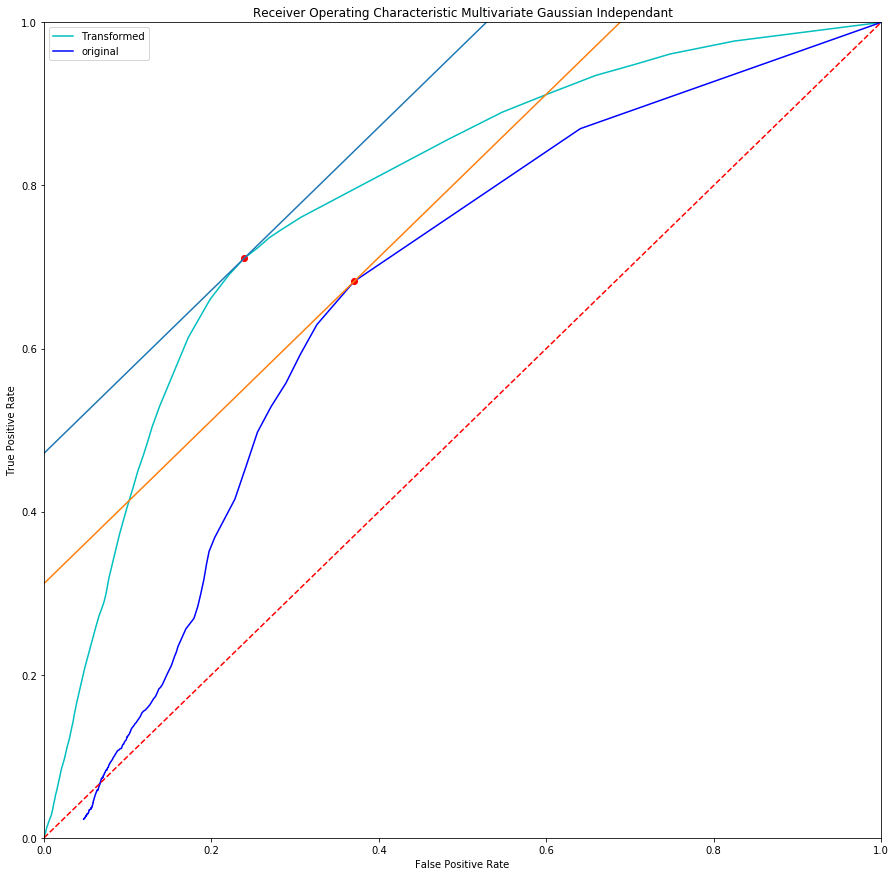

In [92]:
# the point that maximizes the TPR while minimzing the FPR 
# (assuming equal weight) lies on a line with a slope = 1
# that maximizies the y intercept

intercept_mvg_trans = optimize_df4['tpr'] - optimize_df4['fpr']
i_optimal_mvg_trans = intercept_mvg_trans.values.argmax()     # index of optimal threshold

# method I: plt
plt.figure(figsize=(15,15))
plt.title('Receiver Operating Characteristic Multivariate Gaussian Independant')
plt.plot(optimize_df4['fpr'],optimize_df4['tpr'], 'c',label='Transformed')
plt.plot(optimize_df2['fpr'],optimize_df2['tpr'], 'b',label='original')
plt.legend()
plt.plot([0, 1], [0, 1],'r--')

# plot optimal point and line w/slope 1 through optimal
plt.plot(optimize_df4['fpr'].iloc[i_optimal_mvg_trans],
         optimize_df4['tpr'].iloc[i_optimal_mvg_trans],
         'ro')
x = np.linspace(0,1)
plt.plot(x, 1 * x  + intercept_mvg_trans.iloc[i_optimal_mvg_trans])

# plot optimal point and line w/slope 1 through optimal
plt.plot(optimize_df2['fpr'].iloc[i_optimal_mvg],
         optimize_df2['tpr'].iloc[i_optimal_mvg],
         'ro')
x = np.linspace(0,1)
plt.plot(x, 1 * x  + intercept_mvg.iloc[i_optimal_mvg])

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [93]:
print('Multivariate gaussian independant Original')
print('Epsilon = '+str(optimize_df2.at[i_optimal_mvg,'Epsilon']))
print('False Positive Rate = '+str(optimize_df2.at[i_optimal_mvg,'fpr']))
print('True Positive Rate = '+str(optimize_df2.at[i_optimal_mvg,'tpr']))
print('\n')
print('Multivariate gaussian independant Transformed')
print('Epsilon = '+str(optimize_df4.at[i_optimal_mvg_trans,'Epsilon']))
print('False Positive Rate = '+str(optimize_df4.at[i_optimal_mvg_trans,'fpr']))
print('True Positive Rate = '+str(optimize_df4.at[i_optimal_mvg_trans,'tpr']))

Multivariate gaussian independant Original
Epsilon = 1e-07
False Positive Rate = 0.3705574690649317
True Positive Rate = 0.6824755092520604


Multivariate gaussian independant Transformed
Epsilon = 5e-09
False Positive Rate = 0.2392652123995408
True Positive Rate = 0.710931425905769


As it can be seen, the false positive rate is significantly lower when it is transformed (which is good!) and the true positive rate is slightly higher which is a big improvement over the original dataset! It can also be seen that the multivariate independant gaussian transformed is better than the multivariate dependant gaussian transformed in terms of performance as well! 

# Question 3 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Attempt of LSTM neural net
## 4 hidden layers 

In [ ]:
# csv names
file_name_normal = "merged_exp_normal.csv"
file_name_anomalies = "merged_exp_contains_anomalies.csv"

In [ ]:
# read input data

# load the anomalous test data
df_anomaly = pd.read_csv(file_name_anomalies, index_col = 0)

# separate the anomaly tags
true_labels = pd.DataFrame(df_anomaly['Anomaly_Tag'])

# select only the columns we care about
df_anomaly.drop(columns=['Sds_Armed', 'Anomaly_Tag', 'experiment'], inplace=True)
sns.countplot(x = 'Anomaly_Tag', data=true_labels)

In [ ]:
# Do our train / test splitting (80/20)

input_train, input_test, output_train, output_test = train_test_split(df_anomaly, true_labels, test_size=0.2, random_state=30)

print("input_train: ")
print(input_train.describe())
print("\n")
print("input_train: ")
print(input_test.describe())

In [ ]:
# scale the inputs such that mean = 0, and standard deviation = 1
scaler = StandardScaler()

input_train = scaler.fit_transform(input_train)
input_test = scaler.fit_transform(input_test)

input_train_df = pd.DataFrame(input_train)
input_test_df = pd.DataFrame(input_test)
print("input_train: ")
print(input_train_df.describe())
print("\n")
print("input_train: ")
print(input_test_df.describe())

In [ ]:
# these are hyper parameters. will need to be played with later! 

epochs = 75
batch_size = 128
lr = 0.001

In [ ]:
# define out training data class 

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


# call the training class to store our data     
train_data = trainData(torch.FloatTensor(input_train), 
                       torch.FloatTensor(output_train.to_numpy()))


In [ ]:
# define the class to store our test data

## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
# call the test data class 
test_data = testData(torch.FloatTensor(input_test))

In [ ]:
# define our data loaders 

# use batches of 64 for the training data, also make sure to shuffle data 
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# use batche of 1 for the test data 
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
# define our binary classification neural net! 

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(8, 128) 
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_4 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1) 
        
        #rectified Linear Unit, 0 until 0, x after 0. Used as an activation function into the neuron!
        self.relu = nn.ReLU()
        
        # Sensitizes the nodes to neighbooring nodes 
        self.dropout = nn.Dropout(p=0.1)
        
        # Normalize the output of the neural node by substracting the mean and dividing by standard deviation of all output nodes
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.batchnorm4 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        
        # define the forward propagation
        
        # ReLu activation of inputs
        x = self.relu(self.layer_1(inputs))
        
        # normalize the output of layer 1
        x = self.batchnorm1(x)
        
        # ReLU activation of output layer 1
        x = self.relu(self.layer_2(x))
        
        # normalize the otuput of layer 2 
        x = self.batchnorm2(x)
        
        # apply dropout 
        x = self.dropout(x)
        
        # Apply ReLu activation of output layer 3 
        x = self.relu(self.layer_3(x))
        
        # apply batchnorm
        x = self.batchnorm3(x)
        
        # apply dropout
        x=self.dropout(x)
        
        # Apply ReLu activation of output layer 4
        x = self.relu(self.layer_4(x))
        
        # apply batchnorm
        x = self.batchnorm4(x)
        
        # apply dropout
        x=self.dropout(x)
        
        # find the output using a sigmoid function (will be defined later don't worry!!!)
        x = self.layer_out(x)
        
        return x

In [ ]:
# see what device you can use (GPU OR CPU)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# instantiate our model class 
model = binaryClassification()

# evaluate the model using available devices 
model.to(device)
print(model)

# define our loss fucntion BCE = binary cross entropy 
criterion = nn.BCEWithLogitsLoss()

# define our optimizer 
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
# define the training function Gives back accuracy ! 

def binary_acc(y_pred, y_test):
    
    # perform sigmoid function on our y_predicted 
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    # calculate the amount of correct prediction
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    
    # get the accuracy by dividing by the total amount of tests and multiply by 100
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
# train the model!! 
epoch_loss_list = []
epoch_acc_list = []

model.train()
for e in range(1, epochs+1):
    # get rid of last epcho loss and accuracy measurements
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        
        # load the xtrain data and ytrain data to device 
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # reset the optimizer to zero
        optimizer.zero_grad()
        
        # make the prediction 
        y_pred = model(X_batch)
        
        # apply the loss criterion based on y_predict and y_batch 
        loss = criterion(y_pred, y_batch)
        
        # calculate the accuracy 
        acc = binary_acc(y_pred, y_batch)
        
        # apply backwards propagation (LSTM model)
        loss.backward()
        
        # have the optimizer take a step
        optimizer.step()
        
        # get loss and accuracy items 
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    # print the results
    epoch_loss_list.append(epoch_loss/len(train_loader))
    epoch_acc_list.append(epoch_acc/len(train_loader))
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

In [ ]:
# plot epoch loss
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 15))
plt.plot(epoch_loss_list)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title("Epoch Loss")
plt.show()

In [ ]:
# plot epoch loss
fig, ax = plt.subplots(figsize=(15, 15))
plt.style.use('dark_background')
plt.plot(epoch_acc_list)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title("Epoch Accuracy")
plt.show()

In [ ]:
# initiate a list for all predictions on xtest 
y_pred_list = []

# make sure dropout and batchnorm are operating in eval mode rather than training mode
model.eval()

# torch.no_grad() makes sure backwards propagation is not computed and lowers memory requirements of program 
with torch.no_grad():
    for X_batch in test_loader:
        
        # send xbatch to device 
        X_batch = X_batch.to(device)
        
        # predict
        y_test_pred = model(X_batch)
        
        # apply sigmoid to result 
        y_test_pred = torch.sigmoid(y_test_pred)
        
        # round off our results 
        y_pred_tag = torch.round(y_test_pred)
        
        # send y_predict to our a numpy array 
        y_pred_list.append(y_pred_tag.cpu().numpy())

# convert numpy array to list 
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
# calculate relevant statistics 

TN, FP, FN, TP = confusion_matrix(output_test, y_pred_list).ravel()
TPR = TP/(TP+FN)
FPR =1-(TN/(TN+FP))

print("True Negative= "+str(TN))
print("True Positive= "+str(TP))
print("False Negative= "+str(FN))
print("False Positive= "+str(FP))
print("True Positive Rate= "+str(TPR))
print("False Positive Rate= "+str(FPR))

In [ ]:
# calculate relevant statistics 
print(classification_report(output_test, y_pred_list))

### Detection Capabilities
| Phase | Independant Gaussian (x1+X5) | Independant Gaussian (xAll) | Multivariate Gaussian | Supervised learning (SGD linear classifier) | Clustering approach (K-means) |
| --- | --- | --- | --- | --- | --- |
| Precision | 39.28% | 38.69% | 28.17% | 47.44% | 28.79% |
| Recall | 10.84% | 68.71% | 100% | 9.11% | 14.04% |
| F-value |  16.9% | 49.51% | 43.96% | 15.2% | 18.9% | 

### Detection Capabilities Based On number of Hidden Layers
| Phase | NN HiddenLayer 1 |  NN HiddenLayer 2 |  NN HiddenLayer 3 | NN HiddenLayer 4 |  NN HiddenLayer 5|
| --- | --- | --- | --- | --- | --- |
| Precision | 83% | 88% | 89% | 90% | 96% |
| Recall | 35% | 62% | 79% | 84% | 75% |
| F-value |  50% | 73% | 83% | 87% | 85% | 

### Analysis of detection capabilities
It is plain to see that even a simple Neural network is capable of producing better results than the statistical models in this application. Without really exploring the number of nodes in each layer as well as normalization to prevent overfitting, it was able to get more accurate prediction than any of the models in assignment 1. 

### Time/Memory Complexity Big O notation
| Phase | Independant Gaussian  | Multivariate Gaussian | Supervised learning (SGD linear classifier) | Clustering approach (K-means) | Neural Net | 
| --- | --- | --- | --- | --- | --| 
| Training  | O(2nm) | O(nm+n^3*m) | O((n+1)me) | O(2nme) | O(e[4IH+4H2+3H+HK]) | 
| Execution | O(nm) | O(n^3*m) | O(nm) | O(2nm) | O(nH+O(sigmoid)) | 

* In the neural net: I = number of inputs, H = number of cells in hidden layer for an LSTM network 
* External notes taken from Sudeep Raja doctoral student from columbia university 
* Link to Power point referenced http://cse.iitkgp.ac.in/~psraja/FNNs%20,RNNs%20,LSTM%20and%20BLSTM.pdf
* cross validated answer with the following paper which confirmed it is O(W) 
https://www.bioinf.jku.at/publications/older/2604.pdf
* modified such that it included the number of epoches e
* For computing execution time, it is just the number of inputs I * the number of hidden cells in the layers (the weights) plus the activation function 

# Extra code for different neural net hidden layers

In [ ]:
#  Hidden layer 1 

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(8, 64) 
        self.layer_out = nn.Linear(64, 1) 
        
        #rectified Linear Unit, 0 until 0, x after 0. Used as an activation function into the neuron!
        self.relu = nn.ReLU()
        
        # Sensitizes the nodes to neighbooring nodes 
        self.dropout = nn.Dropout(p=0.1)
        
        # Normalize the output of the neural node by substracting the mean and dividing by standard deviation of all output nodes
        self.batchnorm1 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        
        # define the forward propagation
        
        # ReLu activation of inputs
        x = self.relu(self.layer_1(inputs))
        
        # normalize the output of layer 1
        x = self.batchnorm1(x)
        
        # apply dropout 
        x = self.dropout(x)
        
        # find the output using a sigmoid function (will be defined later don't worry!!!)
        x = self.layer_out(x)
        
        return x

In [ ]:
# Hidden layer 2

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(8, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        #rectified Linear Unit, 0 until 0, x after 0. Used as an activation function into the neuron!
        self.relu = nn.ReLU()
        
        # Sensitizes the nodes to neighbooring nodes 
        self.dropout = nn.Dropout(p=0.1)
        
        # Normalize the output of the neural node by substracting the mean and dividing by standard deviation of all output nodes
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        
        # define the forward propagation
        
        # ReLu activation of inputs
        x = self.relu(self.layer_1(inputs))
        
        # normalize the output of layer 1
        x = self.batchnorm1(x)
        
        # ReLU activation of output layer 1
        x = self.relu(self.layer_2(x))
        
        # normalize the otuput of layer 2 
        x = self.batchnorm2(x)
        
        # apply dropout 
        x = self.dropout(x)
        
        # find the output using a sigmoid function (will be defined later don't worry!!!)
        x = self.layer_out(x)
        
        return x

In [ ]:
# hidden layer 3

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(8, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1) 
        
        #rectified Linear Unit, 0 until 0, x after 0. Used as an activation function into the neuron!
        self.relu = nn.ReLU()
        
        # Sensitizes the nodes to neighbooring nodes 
        self.dropout = nn.Dropout(p=0.1)
        
        # Normalize the output of the neural node by substracting the mean and dividing by standard deviation of all output nodes
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        
        # define the forward propagation
        
        # ReLu activation of inputs
        x = self.relu(self.layer_1(inputs))
        
        # normalize the output of layer 1
        x = self.batchnorm1(x)
        
        # ReLU activation of output layer 1
        x = self.relu(self.layer_2(x))
        
        # normalize the otuput of layer 2 
        x = self.batchnorm2(x)
        
        # apply dropout 
        x = self.dropout(x)
        
        # Apply ReLu activation of output layer 3 
        x = self.relu(self.layer_3(x))
        
        # apply batchnorm
        x = self.batchnorm3(x)
        
        # apply dropout
        x=self.dropout(x)
        
        # find the output using a sigmoid function (will be defined later don't worry!!!)
        x = self.layer_out(x)
        
        return x

In [ ]:
# Hidden layer 5 

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(8, 128) 
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_4 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1) 
        
        #rectified Linear Unit, 0 until 0, x after 0. Used as an activation function into the neuron!
        self.relu = nn.ReLU()
        
        # Sensitizes the nodes to neighbooring nodes 
        self.dropout = nn.Dropout(p=0.1)
        
        # Normalize the output of the neural node by substracting the mean and dividing by standard deviation of all output nodes
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.batchnorm4 = nn.BatchNorm1d(32)
        
    def forward(self, inputs):
        
        # define the forward propagation
        
        # ReLu activation of inputs
        x = self.relu(self.layer_1(inputs))
        
        # normalize the output of layer 1
        x = self.batchnorm1(x)
        
        # ReLU activation of output layer 1
        x = self.relu(self.layer_2(x))
        
        # normalize the otuput of layer 2 
        x = self.batchnorm2(x)
        
        # apply dropout 
        x = self.dropout(x)
        
        # Apply ReLu activation of output layer 3 
        x = self.relu(self.layer_3(x))
        
        # apply batchnorm
        x = self.batchnorm3(x)
        
        # apply dropout
        x=self.dropout(x)
        
        # Apply ReLu activation of output layer 4
        x = self.relu(self.layer_4(x))
        
        # apply batchnorm
        x = self.batchnorm4(x)
        
        # apply dropout
        x=self.dropout(x)
        
        # find the output using a sigmoid function (will be defined later don't worry!!!)
        x = self.layer_out(x)
        
        return x

In [ ]:
# Hidden layer 5 
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(8, 128) 
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_4 = nn.Linear(64, 32)
        self.layer_5 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1) 
        
        #rectified Linear Unit, 0 until 0, x after 0. Used as an activation function into the neuron!
        self.relu = nn.ReLU()
        
        # Sensitizes the nodes to neighbooring nodes 
        self.dropout = nn.Dropout(p=0.1)
        
        # Normalize the output of the neural node by substracting the mean and dividing by standard deviation of all output nodes
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        self.batchnorm4 = nn.BatchNorm1d(32)
        self.batchnorm5 = nn.BatchNorm1d(16)
        
    def forward(self, inputs):
        
        # define the forward propagation
        
        # ReLu activation of inputs
        x = self.relu(self.layer_1(inputs))
        
        # normalize the output of layer 1
        x = self.batchnorm1(x)
        
        # ReLU activation of output layer 1
        x = self.relu(self.layer_2(x))
        
        # normalize the otuput of layer 2 
        x = self.batchnorm2(x)
        
        # apply dropout 
        x = self.dropout(x)
        
        # Apply ReLu activation of output layer 3 
        x = self.relu(self.layer_3(x))
        
        # apply batchnorm
        x = self.batchnorm3(x)
        
        # apply dropout
        x=self.dropout(x)
        
        # Apply ReLu activation of output layer 4
        x = self.relu(self.layer_4(x))
        
        # apply batchnorm
        x = self.batchnorm4(x)
        
        # apply dropout
        x=self.dropout(x)
        
         # Apply ReLu activation of output layer 5
        x = self.relu(self.layer_5(x))
        
        # apply batchnorm
        x = self.batchnorm5(x)
        
        # apply dropout
        x=self.dropout(x)
        
        # find the output using a sigmoid function (will be defined later don't worry!!!)
        x = self.layer_out(x)
        
        return x